#Sales prediction using keras and RNN

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [ ]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [ ]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

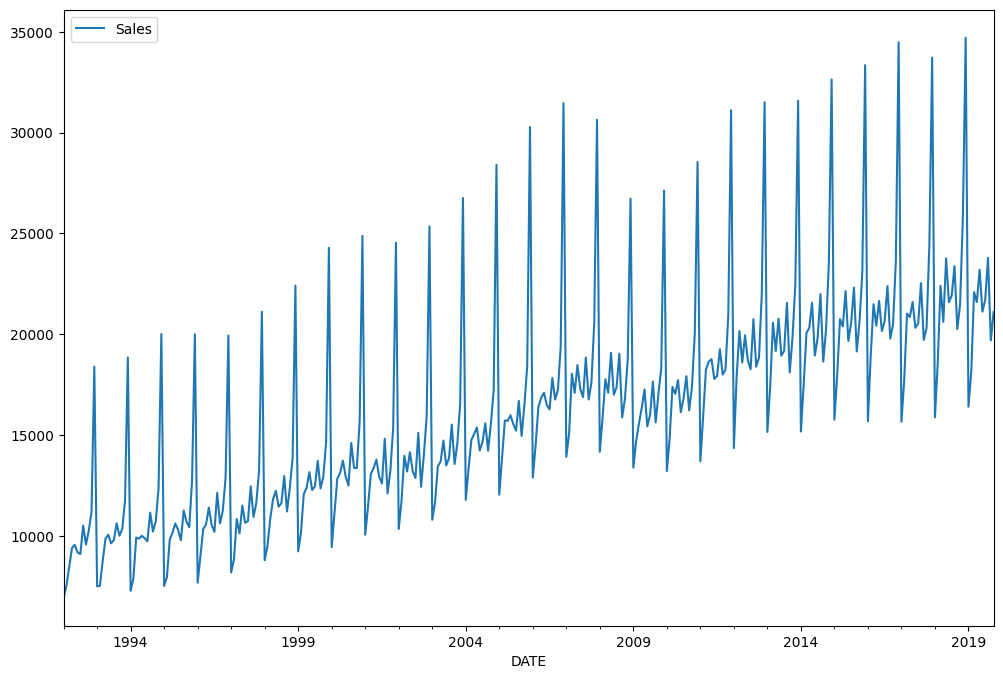

In [ ]:
df.plot(figsize=(12,8))

#Train Test Split

In [ ]:
len(df)

334

In [ ]:
len(df)- 18

316

In [ ]:
test_size = 18

In [ ]:
test_ind = len(df)- test_size

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [ ]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler()

In [ ]:
MinMaxScaler()

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
X,y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [ ]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


<ipython-input-30-8ced39267a06>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 5s 9ms/step - loss: 0.0249 - val_loss: 0.0032
Epoch 2/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0172 - val_loss: 0.0044
Epoch 3/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0097 - val_loss: 0.0141


In [ ]:
losses = pd.DataFrame(model.history.history)

#Loss graph

<Axes: >

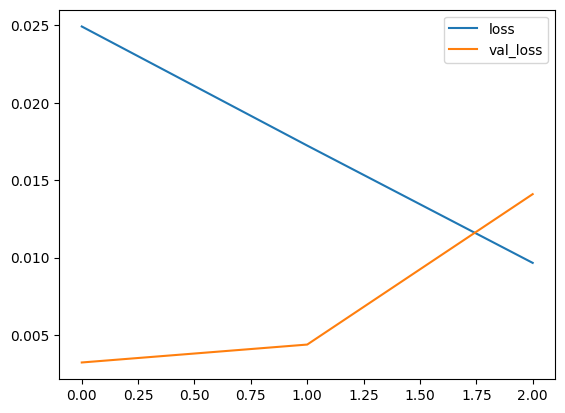

In [ ]:
losses.plot()

In [ ]:
first_eval_batch = scaled_train[-length:]

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [ ]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 195ms/step


array([[0.40239897]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.61087714])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

<ipython-input-39-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [ ]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,18021.677332
2018-06-01,21589,17429.338736
2018-07-01,21919,17406.584076
2018-08-01,23381,18050.101776
2018-09-01,20260,16861.114169
2018-10-01,21473,16985.529293
2018-11-01,25831,18960.461367
2018-12-01,34706,22812.418913
2019-01-01,16410,14723.189121


#Sales & prediction graph

<Axes: xlabel='DATE'>

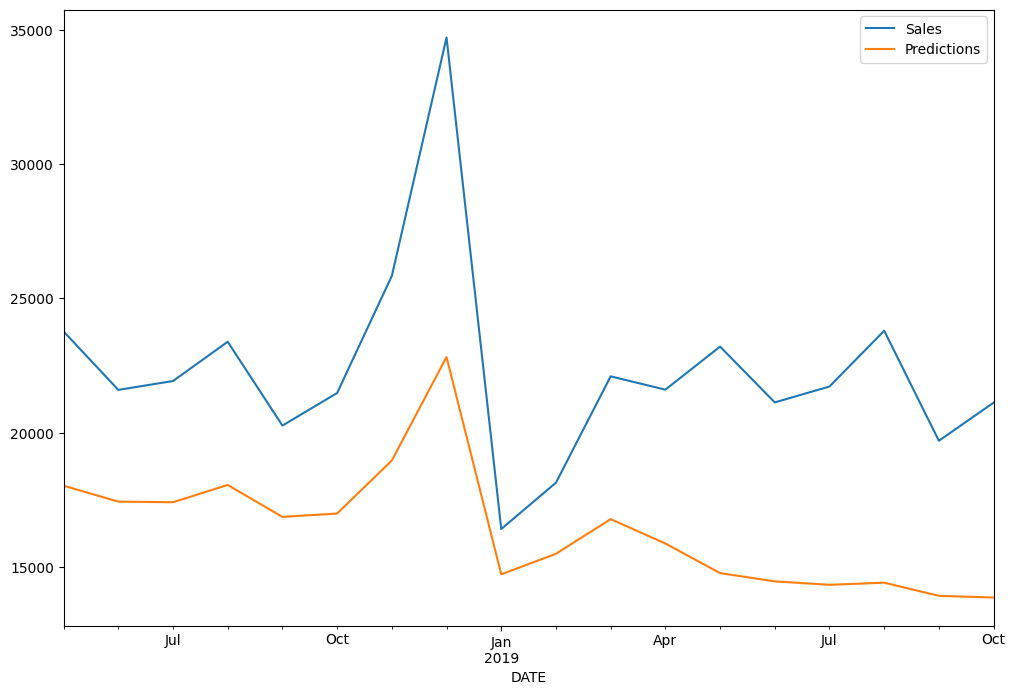

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


<ipython-input-44-74a9761509e5>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


322/322 [==============================] - 4s 8ms/step - loss: 0.0252
Epoch 2/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0183
Epoch 3/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0087
Epoch 4/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0042
Epoch 5/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0042
Epoch 6/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0024
Epoch 7/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0017
Epoch 8/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0018


In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [ ]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [ ]:
forcast_i=pd.date_range(start='2019-11-01',periods=periods,freq='W')
forcast_i

DatetimeIndex(['2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
               '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22',
               '2019-12-29', '2020-01-05', '2020-01-12', '2020-01-19'],
              dtype='datetime64[ns]', freq='W-SUN')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-11-01,26648.155145
2019-12-01,36411.355443
2020-01-01,17631.599915
2020-02-01,19506.635585
2020-03-01,22827.820173
2020-04-01,22424.456891
2020-05-01,23843.961842
2020-06-01,22074.941379
2020-07-01,22661.166096
2020-08-01,24451.389765


#Forecast plot

<Axes: >

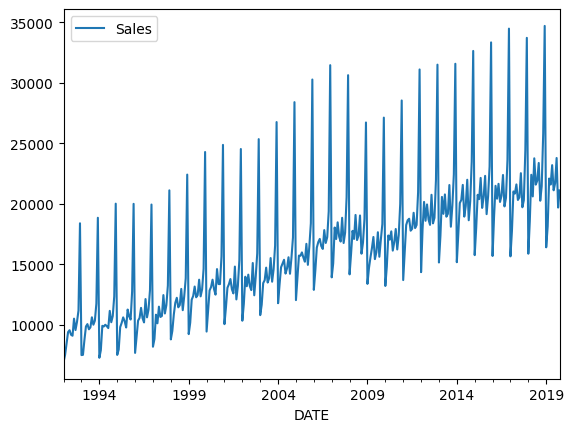

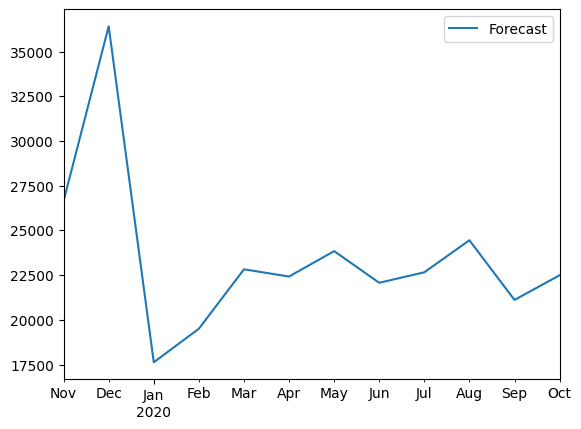

In [ ]:
df.plot()
forecast_df.plot()

#Sales & forecast plot

<Axes: xlabel='DATE'>

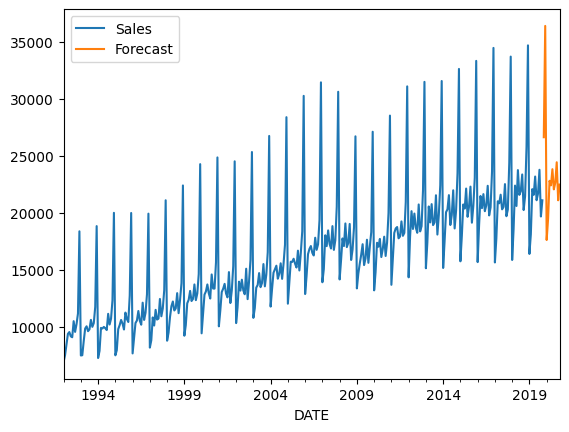

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

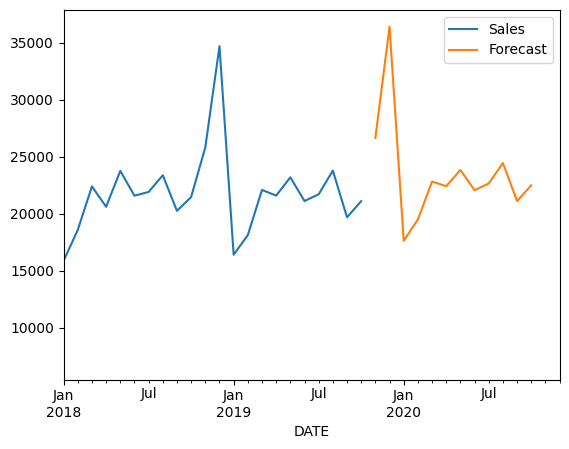

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')